
## Task 3 : Data Collection in the Wild [2 marks]

## Task Description
For this exercise marks will not depend on what numbers you get but on the process you followed Utilize apps like `Physics Toolbox Suite` from your smartphone to collect your data in .csv/.txt format. Ensure at least 15 seconds of data is collected, trimming edges to obtain 10 seconds of relevant data. Also record a video of yourself while recording data. This video will be required in some future assignments. Collect 3-5 samples per activity class.

### Things to take care of:
* Ensure the phone is placed in the same position for all the activities.
* Ensure the phone is in the same alignment during the activity as changing the alignment will change the data collected and will affect the model's performance.
* Ensure to have atleast 10s of data per file for training. As the data is collected at 50Hz, you will have 500 data samples.



IMPORTS

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
from tsfel import time_series_features_extractor, get_features_by_domain
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


# Importing data from MakeDataset.py
from MakeDataset import X_train, X_test, y_train, y_test


DATASET CREATION FROM RAW DATA

In [4]:
# Paths
raw_data_path = "raw_dataset"         # your raw dataset path
processed_data_path = "processed_dataset"

# Activities
ACTIVITIES = ["LAYING", "SITTING", "STANDING", 
              "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]

# Create processed dataset folder structure
os.makedirs(processed_data_path, exist_ok=True)
for activity in ACTIVITIES:
    os.makedirs(os.path.join(processed_data_path, activity), exist_ok=True)

def process_file(filepath, savepath):
    # Load data (assuming CSV; change if txt or other format)
    df = pd.read_csv(filepath)
    
    rename_map = {
        "ax (m/s^2)": "accx",
        "ay (m/s^2)": "accy",
        "az (m/s^2)": "accz"
    }
    df = df.rename(columns=rename_map)

    # Downsample from 100 Hz to 50 Hz → take every 2nd sample
    df = df.iloc[::2].reset_index(drop=True)

    # Ensure at least 15s (750 rows at 50Hz)
    if len(df) < 750:
        print(f"Skipping {filepath} - not enough data")
        return

    # Trim to keep 10s (500 rows) from center
    start = (len(df) - 500) // 2
    end = start + 500
    df = df.iloc[start:end].reset_index(drop=True)

    # Save processed file
    df.to_csv(savepath, index=False)
    print(f"Processed: {savepath}")

# Process all files
for activity in ACTIVITIES:
    raw_folder = os.path.join(raw_data_path, activity)
    save_folder = os.path.join(processed_data_path, activity)

    for filename in os.listdir(raw_folder):
        if filename.endswith(".csv"):  # change if needed
            raw_file = os.path.join(raw_folder, filename)
            save_file = os.path.join(save_folder, filename)
            process_file(raw_file, save_file)

print("✅ Processing complete! Downsampled data saved in processed_dataset/")


Processed: processed_dataset\LAYING\sample_1.csv
Processed: processed_dataset\LAYING\sample_2.csv
Processed: processed_dataset\LAYING\sample_3.csv
Processed: processed_dataset\LAYING\sample_4.csv
Processed: processed_dataset\SITTING\sample_1.csv
Processed: processed_dataset\SITTING\sample_2.csv
Processed: processed_dataset\SITTING\sample_3.csv
Processed: processed_dataset\SITTING\sample_4.csv
Processed: processed_dataset\STANDING\sample_1.csv
Processed: processed_dataset\STANDING\sample_2.csv
Processed: processed_dataset\STANDING\sample_3.csv
Processed: processed_dataset\STANDING\sample_4.csv
Processed: processed_dataset\WALKING\sample_1.csv
Processed: processed_dataset\WALKING\sample_2.csv
Processed: processed_dataset\WALKING\sample_3.csv
Processed: processed_dataset\WALKING\sample_4.csv
Processed: processed_dataset\WALKING_DOWNSTAIRS\sample_1.csv
Processed: processed_dataset\WALKING_DOWNSTAIRS\sample_2.csv
Processed: processed_dataset\WALKING_DOWNSTAIRS\sample_3.csv
Processed: proces

EXPLORATORY PLOTTING


 Laying
       time    accx    accy    accz  aT (m/s^2)
0  3.590525 -0.0609  0.0805 -0.0211       0.103
1  3.605849 -0.1073  0.0382  0.1761       0.210
2  3.620807 -0.1647 -0.0024  0.3151       0.356
SHAPE: (500, 5)

 Sitting
       time    accx    accy    accz  aT (m/s^2)
0  4.128472 -0.0731  0.0722  0.0154       0.104
1  4.144384 -0.0500  0.0392  0.1886       0.199
2  4.162870 -0.0649  0.0894  0.0312       0.115
SHAPE: (500, 5)

 Standing
       time    accx    accy    accz  aT (m/s^2)
0  3.682109 -0.0214  0.0952  0.0898       0.133
1  3.697365 -0.0190  0.1036  0.0870       0.137
2  3.714260  0.0121  0.0994 -0.0975       0.140
SHAPE: (500, 5)

 Walking
       time    accx    accy    accz  aT (m/s^2)
0  3.583039  5.0520 -2.1494 -1.0630       5.592
1  3.595936  4.3647 -2.0862 -1.1589       4.974
2  3.611821  2.8869 -1.6855 -0.6267       3.401
SHAPE: (500, 5)

 Walking Downstairs
       time    accx    accy    accz  aT (m/s^2)
0  3.777411 -0.3755 -1.1749  0.3671       1.287
1  3.791554

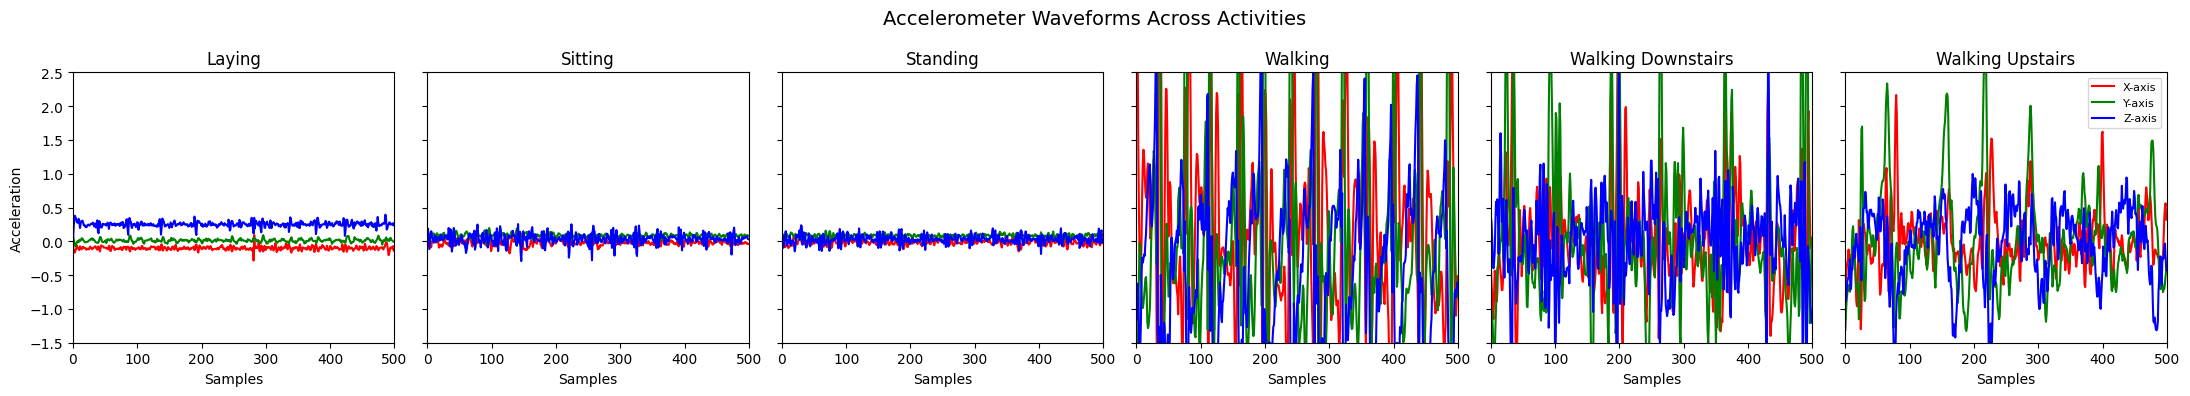

In [1]:
def pick_one_file_per_activity(base_dir):
    """
    Selects one CSV file from each activity folder.
    """
    chosen_files = []
    titles = []
    for activity in ACTIVITIES:
        folder = os.path.join(base_dir, activity)
        file = os.listdir(folder)[0]   # take the first CSV
        chosen_files.append(os.path.join(folder, file))
        titles.append(activity.title().replace("_", " "))
    return chosen_files, titles


def plot_activity_signals(file_paths, titles):
    """
    Plots accelerometer signals (X, Y, Z) for each selected activity.
    """
    fig, axes = plt.subplots(1, 6, figsize=(22, 4), sharey=True)
    fig.suptitle("Accelerometer Waveforms Across Activities", fontsize=14)

    for i, (file, ax) in enumerate(zip(file_paths, axes)):
        # Load one sample and trim to first 500 values
        df = pd.read_csv(file).iloc[:500, :]
        print("\n",titles[i])
        print(df.head(3))
        print("SHAPE:",df.shape)

        ax.plot(df["accx"], color="red", label="X-axis")
        ax.plot(df["accy"], color="green", label="Y-axis")
        ax.plot(df["accz"], color="blue", label="Z-axis")

        ax.set_title(titles[i])
        ax.set_xlim([0, 500])
        ax.set_ylim([-1.5, 2.5])
        ax.set_xlabel("Samples")
        if i == 0:
            ax.set_ylabel("Acceleration")
        if i == 5:  # show legend only on last subplot
            ax.legend(fontsize=8, loc="upper right")

    plt.tight_layout()
    plt.show()


# -------- MAIN --------
if __name__ == "__main__":
    base_path = os.path.join("processed_dataset")
    files, titles = pick_one_file_per_activity(base_path)
    plot_activity_signals(files, titles)



#### Question 1
1. Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform? **[1 marks]**

In [6]:

# ---------------- Step 2: TSFEL Features ----------------
def tsfel_features(X, y,feature):
    # Define TSFEL feature set (time + spectral)
    cfg = get_features_by_domain(feature)
    tsfel_feats = []
    for i in range(len(X)):
        series = pd.DataFrame({"acc_mag": X[i]})
        feat = time_series_features_extractor(cfg, series, verbose=0)
        tsfel_feats.append(feat.values.flatten())
    tsfel_feats = np.array(tsfel_feats)
    return tsfel_feats, y



# Shape of original data from MakeDataset.py
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Flatten X_train and X_test into 2D data
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# New data shape
print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"y_train shape: {y_train.shape}")

# Training decision tree using sklearn on raw data
model_1 = DecisionTreeClassifier(random_state=42)
model_1.fit(X_train_flat, y_train)
 
# Get training and test data 
X_train_provided = pd.read_csv("UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None)
y_train_provided = pd.read_csv("UCI HAR Dataset/train/y_train.txt", delim_whitespace=True, header=None).values.ravel()

# Check shape
print("X_train_provided shape:", X_train_provided.shape)
print("y_train_provided shape:", y_train_provided.shape)

# Train decision tree on features defined by the dataset
model_2 = DecisionTreeClassifier(random_state=42)
model_2.fit(X_train_provided, y_train_provided)


# Get training and test data tsfel
feature="all"
tsfel_X_2, tsfel_y = tsfel_features(X_train_flat, y_train,feature)
print("tsfel_X_2 shape:", tsfel_X_2.shape)
print("tsfel_y shape:", tsfel_y.shape)

model_3 = DecisionTreeClassifier(random_state=42)
model_3.fit(tsfel_X_2, tsfel_y)


X_train shape: (126, 500, 3)
y_train shape: (126,)
X_train_flat shape: (126, 1500)
y_train shape: (126,)
X_train_provided shape: (7352, 561)
y_train_provided shape: (7352,)


C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extr

tsfel_X_2 shape: (126, 162)
tsfel_y shape: (126,)


DecisionTreeClassifier(random_state=42)

TESTING THE MODEL ON OUR RAW DATASET

X_new shape: (24, 1500)
y_true shape: (24,)
[6 6 4 6 6 6 6 6 6 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6] [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6]

=== Classification Report ===
                    precision    recall  f1-score   support

           WALKING       0.00      0.00      0.00         4
  WALKING_UPSTAIRS       0.00      0.00      0.00         4
WALKING_DOWNSTAIRS       0.00      0.00      0.00         4
           SITTING       0.00      0.00      0.00         4
          STANDING       0.00      0.00      0.00         4
            LAYING       0.18      1.00      0.31         4

          accuracy                           0.17        24
         macro avg       0.03      0.17      0.05        24
      weighted avg       0.03      0.17      0.05        24


=== Precision, Recall, Accuracy per Class ===
WALKING: Precision = 0.0000, Recall = 0.0000, Accuracy = 0.8333
WALKING_UPSTAIRS: Precision = 0.0000, Recall = 0.0000, Accuracy = 0.8333
WALKING_DOWNSTAIRS: Precision = 0.0000

c:\Users\Aeshaa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aeshaa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aeshaa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

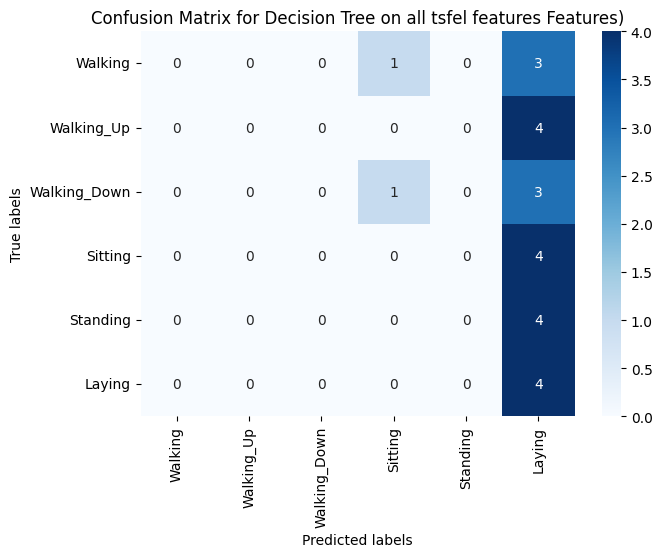

In [ ]:

# Path where all processed datasets are stored
data_dir = "processed_dataset"

# Class mapping (labels from dataset)
classes = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}


X_list = []
y_list = []

# Loop over each activity
for i, activity in enumerate(activities):
    activity_path = os.path.join(data_dir, activity)
    
    # Loop over all CSV samples inside this activity folder
    for file in os.listdir(activity_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(activity_path, file))
            
            # Use only accx, accy, accz
            X_sample = df[["accx", "accy", "accz"]].values  
            
            # Only accept samples with exactly 500 rows (10s @ 50Hz)
            if X_sample.shape[0] == 500:
                X_list.append(X_sample.reshape(-1))  # flatten (1500 features)
                y_list.append(i+1)  # activity labels 1–6

# Convert to numpy arrays
X_new = np.array(X_list)
y_true = np.array(y_list)

print("X_new shape:", X_new.shape)  
print("y_true shape:", y_true.shape)  

# Predict activities with model_1
y_pred = model_1.predict(X_new)

print(y_pred,y_true)

# === Overall Metrics ===
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

# === Per-class Precision, Recall, Accuracy ===
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

print("\n=== Precision, Recall, Accuracy per Class ===")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_true == class_label, y_pred == class_label)
    print(f"{classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

# === Macro Averages ===
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print("\n=== Overall Performance ===")
print(f"Overall Precision (Macro): {precision_macro:.4f}")
print(f"Overall Recall (Macro): {recall_macro:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")

# === Confusion Matrix ===
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_true, y_pred)



plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Walking","Walking_Up","Walking_Down","Sitting","Standing","Laying"],
            yticklabels=["Walking","Walking_Up","Walking_Down","Sitting","Standing","Laying"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for Decision Tree on raw dataset)")
plt.show()

C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extr

tsfel_X_2 shape: (24, 162)
tsfel_y shape: (24,)
[3 3 3 3 6 6 6 6 6 6 6 6 6 6 6 6 3 3 3 3 3 3 3 3] [1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6]

=== Classification Report ===
                    precision    recall  f1-score   support

           WALKING       0.00      0.00      0.00       4.0
  WALKING_UPSTAIRS       0.00      0.00      0.00       4.0
WALKING_DOWNSTAIRS       0.00      0.00      0.00       4.0
           SITTING       0.00      0.00      0.00       4.0
          STANDING       0.00      0.00      0.00       4.0
            LAYING       0.00      0.00      0.00       4.0

          accuracy                           0.00      24.0
         macro avg       0.00      0.00      0.00      24.0
      weighted avg       0.00      0.00      0.00      24.0


=== Precision, Recall, Accuracy per Class ===
WALKING: Precision = 0.0000, Recall = 0.0000, Accuracy = 0.8333
WALKING_UPSTAIRS: Precision = 0.0000, Recall = 0.0000, Accuracy = 0.8333
WALKING_DOWNSTAIRS: Precision = 0.

c:\Users\Aeshaa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aeshaa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aeshaa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

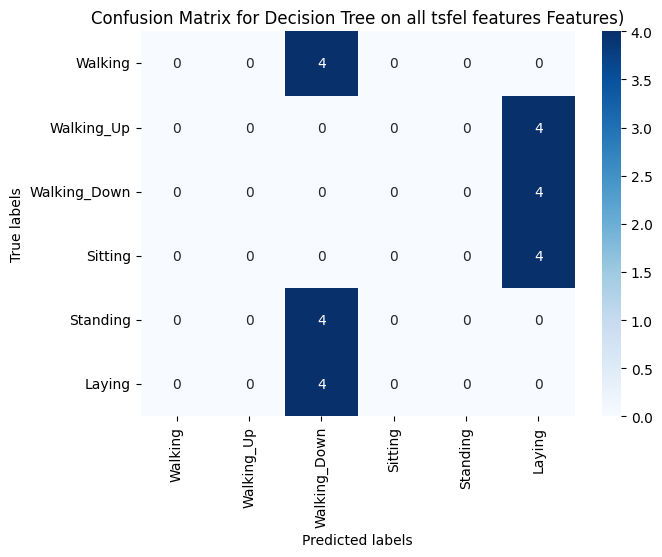

In [14]:

# Get training and test data tsfel
feature="all"
tsfel_X_2, tsfel_y = tsfel_features(X_new, y_true,feature)
print("tsfel_X_2 shape:", tsfel_X_2.shape)
print("tsfel_y shape:", tsfel_y.shape)

y_pred = model_3.predict(tsfel_X_2)

print(y_pred,y_true)

# === Overall Metrics ===
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

# === Per-class Precision, Recall, Accuracy ===
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

print("\n=== Precision, Recall, Accuracy per Class ===")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_true == class_label, y_pred == class_label)
    print(f"{classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

# === Macro Averages ===
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print("\n=== Overall Performance ===")
print(f"Overall Precision (Macro): {precision_macro:.4f}")
print(f"Overall Recall (Macro): {recall_macro:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")

# === Confusion Matrix ===
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_true, y_pred)



plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Walking","Walking_Up","Walking_Down","Sitting","Standing","Laying"],
            yticklabels=["Walking","Walking_Up","Walking_Down","Sitting","Standing","Laying"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for Decision Tree on all tsfel features Features)")
plt.show()

Dataset shape: (24, 1500) Labels: (24,)


C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extractor(cfg, series, verbose=0)
C:\Users\Aeshaa\AppData\Local\Temp\ipykernel_74200\1228755664.py:22: UserWarning: Using default sampling frequency set in configuration file.
  feat = time_series_features_extr

Accuracy: 1.0

Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00         1
           SITTING       1.00      1.00      1.00         1
          STANDING       1.00      1.00      1.00         1
           WALKING       1.00      1.00      1.00         2
WALKING_DOWNSTAIRS       1.00      1.00      1.00         2
  WALKING_UPSTAIRS       1.00      1.00      1.00         1

          accuracy                           1.00         8
         macro avg       1.00      1.00      1.00         8
      weighted avg       1.00      1.00      1.00         8



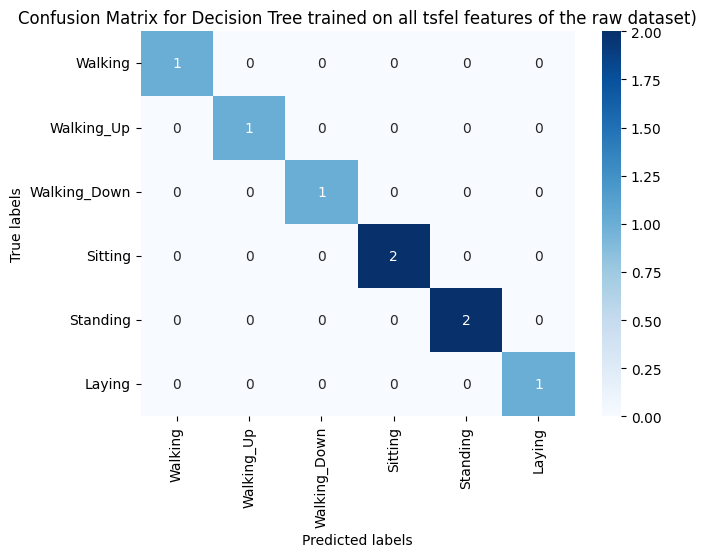

In [19]:

# -----------------------------
# 1. Load all collected data
# -----------------------------
DATASET_PATH = "processed_dataset"   # change to your path
activities = ["WALKING", "SITTING", "STANDING", "LAYING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]

X = []
y = []

for idx, activity in enumerate(activities):
    folder = os.path.join(DATASET_PATH, activity)
    for file in os.listdir(folder):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder, file))
            # Use accx, accy, accz only
            acc = df[["accx", "accy", "accz"]].values  
            # Flatten (500 × 3 → 1500 features)
            X.append(acc.flatten())
            y.append(activity)

X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape, "Labels:", y.shape)

# -----------------------------
# 2. Train-test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# -----------------------------
# 3. Preprocessing (scaling)
# -----------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

feature="all"
tsfel_X_train, tsfel_y_train = tsfel_features(X_train, y_train,feature)
tsfel_X_test, tsfel_y_test = tsfel_features(X_test, y_test,feature)

# -----------------------------
# 4. Train simple model
# -----------------------------
model = RandomForestClassifier(random_state=42)
model.fit(tsfel_X_train, tsfel_y_train)

# -----------------------------
# 5. Predict and Evaluate
# -----------------------------
tsfel_y_pred = model.predict(tsfel_X_test)

print("Accuracy:", accuracy_score(tsfel_y_test, tsfel_y_pred))
print("\nClassification Report:\n", classification_report(tsfel_y_test, tsfel_y_pred))


cm = confusion_matrix(tsfel_y_test, tsfel_y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Walking","Walking_Up","Walking_Down","Sitting","Standing","Laying"],
            yticklabels=["Walking","Walking_Up","Walking_Down","Sitting","Standing","Laying"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for Decision Tree trained on all tsfel features of the raw dataset)")
plt.show()

In [1]:

# -----------------------------
# 1. Load all collected data
# -----------------------------
DATASET_PATH = "processed_dataset"   # change to your path
activities = ["WALKING", "SITTING", "STANDING", "LAYING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]

X = []
y = []

for idx, activity in enumerate(activities):
    folder = os.path.join(DATASET_PATH, activity)
    for file in os.listdir(folder):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder, file))
            # Use accx, accy, accz only
            acc = df[["accx", "accy", "accz"]].values  
            # Flatten (500 × 3 → 1500 features)
            X.append(acc.flatten())
            y.append(activity)

X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape, "Labels:", y.shape)

# -----------------------------
# 2. Train-test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# -----------------------------
# 3. Preprocessing (scaling)
# -----------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# -----------------------------
# 4. Train simple model
# -----------------------------
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# -----------------------------
# 5. Predict and Evaluate
# -----------------------------
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Walking","Walking_Up","Walking_Down","Sitting","Standing","Laying"],
            yticklabels=["Walking","Walking_Up","Walking_Down","Sitting","Standing","Laying"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix for Decision Tree trained on raw dataset)")
plt.show()

Dataset shape: (24, 1500) Labels: (24,)
Accuracy: 0.375


c:\users\sonde\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sonde\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sonde\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Classification Report:
                     precision    recall  f1-score   support

            LAYING       0.33      1.00      0.50         1
           SITTING       0.50      1.00      0.67         1
          STANDING       0.50      1.00      0.67         1
           WALKING       0.00      0.00      0.00         2
WALKING_DOWNSTAIRS       0.00      0.00      0.00         2
  WALKING_UPSTAIRS       0.00      0.00      0.00         1

          accuracy                           0.38         8
         macro avg       0.22      0.50      0.31         8
      weighted avg       0.17      0.38      0.23         8



NameError: name 'confusion_matrix' is not defined